# Introduction

이 노트는 포르투 세구로 대회 자료에서 소개부터 시작합니다. 그런 다음 교차 검증 및 쌓기를 사용하여 몇 가지 예측 모형을 준비하고 실행하고 제출을 준비합니다.


# Analysis packages


In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# npmppss

from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
# VS

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

!pip install lightgbm
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_columns', 100)

# Load the data


In [56]:
trainset = pd.read_csv('./train.csv')
testset = pd.read_csv('./test.csv')

# Few quick observations

We can make few observations based on the data description in the competition:

- Few groups are defined and features that belongs to these groups include patterns in the name (ind, reg, car, calc). The ind indicates most probably individual, reg is probably registration, car is self-explanatory, calc suggests a calculated field;
- The postfix bin is used for binary features;
- The postfix cat to is used for categorical features;
- Features without the bin or cat indications are real numbers (continous values) of integers (ordinal values);
- A missing value is indicated by -1;
- The value that is subject of prediction is in the target column. This one indicates whether or not a claim was filed for that insured person;
- id is a data input ordinal number.

Let's glimpse the data to see if these interpretations are confirmed.



In [57]:
trainset.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


Indeed, we can observe the cat values are categorical, integer values ranging from 0 to n, bin values are binary (either 0 or 1).

Let's see how many rows and columns are in the data.



In [58]:
print("Train dataset (rows, cols):",trainset.shape, "\nTest dataset (rows, cols):",testset.shape)

Train dataset (rows, cols): (595212, 59) 
Test dataset (rows, cols): (892816, 58)


훈련 데이터 세트에는 59개의 열이 있으며 테스트 데이터 세트에는 58개만 있습니다. 
이 데이터 집합에서 target을 추출했어야 하므로, 이것은 괜찮아 보입니다. 
모든 것이 정상인지 확인하기 위해 두 데이터 세트에 설정된 열의 차이를 확인하겠습니다.


In [59]:
print("Columns in train and not in test dataset:",set(trainset.columns)-set(testset.columns))

Columns in train and not in test dataset: {'target'}


In [60]:
print(trainset.columns)

Index(['id', 'target', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03',
       'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin',
       'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin',
       'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15',
       'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01',
       'ps_reg_02', 'ps_reg_03', 'ps_car_01_cat', 'ps_car_02_cat',
       'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat',
       'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat',
       'ps_car_11_cat', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14',
       'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04',
       'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09',
       'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14',
       'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
       'ps_calc_19_bin', 'ps_calc_20_bin'],


# Introduction of metadata

데이터 조작을 쉽게 하기 위해, 우리는 몇 가지 메타 정보를 훈련 집합의 변수와 연관시킬 것입니다. 
이를 통해 분석, 검사 또는 모델링을 위한 다양한 유형의 피쳐를 쉽게 선택할 수 있습니다.
우리는 car, ind, reg 및 calc 유형의 특징에 대한 카테고리 필드도 사용하고 있습니다.

What metadata will be used:

- use: input, ID, target
- type: nominal, interval(real), ordinal(integer), binary
- preserve: True or False
- dataType: int, float, char
- category: ind, reg, car, calc


In [61]:
data = []
for feature in trainset.columns:
    dtype = trainset[feature].dtype
    
    if 'bin' in feature:
        type = 'binary'
    elif 'cat' in feature:
        type = 'categorical'
    elif trainset[feature].dtype == float:
        type = 'real'
    elif trainset[feature].dtype == int:
        type = 'integer'
        
    feature_dict = {
        'varname' : feature,
        'dtype' : dtype,
        'type' : type
    }
    data.append(feature_dict)
    #print(data)
    
metadata = pd.DataFrame(data, columns = ['varname', 'dtype', 'type'])
metadata.set_index('varname', inplace=True)
metadata

,dtype,type
varname,,
id,int64,binary
target,int64,binary
ps_ind_01,int64,binary
ps_ind_02_cat,int64,categorical
ps_ind_03,int64,categorical
ps_ind_04_cat,int64,categorical
ps_ind_05_cat,int64,categorical
ps_ind_06_bin,int64,binary
ps_ind_07_bin,int64,binary


In [62]:
data = []
for feature in trainset.columns:
    # Defining the role
    if feature == 'target':
        use = 'target'
    elif feature == 'id':
        use = 'id'
    else:
        use = 'input'
         
    # Defining the type
    if 'bin' in feature or feature == 'target':
        type = 'binary'
    elif 'cat' in feature or feature == 'id':
        type = 'categorical'
    elif np.issubdtype(trainset[feature].dtype, np.floating):
        type = 'real'
    elif np.issubdtype(trainset[feature].dtype, np.integer):
        type = 'integer'
        
    # Initialize preserve to True for all variables except for id
    preserve = True
    if feature == 'id':
        preserve = False
    
    # Defining the data type 
    dtype = trainset[feature].dtype
    
    category = 'none'
    # Defining the category
    if 'ind' in feature:
        category = 'individual'
    elif 'reg' in feature:
        category = 'registration'
    elif 'car' in feature:
        category = 'car'
    elif 'calc' in feature:
        category = 'calculated'
    
    
    # Creating a Dict that contains all the metadata for the variable
    feature_dictionary = {
        'varname': feature,
        'use': use,
        'type': type,
        'preserve': preserve,
        'dtype': dtype,
        'category' : category
    }
    data.append(feature_dictionary)
    
metadata = pd.DataFrame(data, columns=['varname', 'use', 'type', 'preserve', 'dtype', 'category'])
metadata.set_index('varname', inplace=True)
metadata

,use,type,preserve,dtype,category
varname,,,,,
id,id,categorical,False,int64,none
target,target,binary,True,int64,none
ps_ind_01,input,integer,True,int64,individual
ps_ind_02_cat,input,categorical,True,int64,individual
ps_ind_03,input,integer,True,int64,individual
ps_ind_04_cat,input,categorical,True,int64,individual
ps_ind_05_cat,input,categorical,True,int64,individual
ps_ind_06_bin,input,binary,True,int64,individual
ps_ind_07_bin,input,binary,True,int64,individual


We can extract, for example, all categorical values:



In [63]:
metadata[(metadata.type == 'categorical') & (metadata.preserve)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

고유한 범주의 값이 몇 개인지 확인하기 위해 모든 기능을 검사하겠습니다.


In [64]:
pd.DataFrame({'count' : metadata.groupby(['category'])['category'].size()}).reset_index()

,category,count
0,calculated,20
1,car,16
2,individual,18
3,none,2
4,registration,3


In [65]:
pd.DataFrame({'count' : metadata.groupby(['use', 'type'])['use'].size()}).reset_index()

,use,type,count
0,id,categorical,1
1,input,binary,17
2,input,categorical,14
3,input,integer,16
4,input,real,10
5,target,binary,1


There are one nominal feature (the id), 20 binary values, 21 real (or float numbers), 16 categorical features - all these being as well input values and one target value, which is as well binary, the target.



# Data analysis and statistics

## Target variable


In [66]:
x = trainset['target'].value_counts().index.values
x

array([0, 1], dtype=int64)

<Figure size 432x288 with 0 Axes>

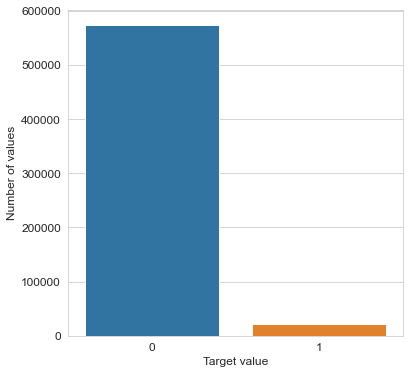

In [67]:
plt.figure()
fig, ax = plt.subplots(figsize=(6,6))
x = trainset['target'].value_counts().index.values # [0, 1]
y = trainset["target"].value_counts().values

# Bar plot
# Order the bars descending on target mean
sns.barplot(ax=ax, x=x, y=y)
plt.ylabel('Number of values', fontsize=12)
plt.xlabel('Target value', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

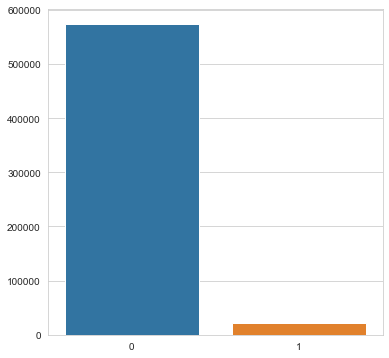

In [68]:
plt.figure()
fig, ax = plt.subplots(figsize = (6,6))
x = trainset['target'].value_counts().index.values
y = trainset['target'].value_counts().values
sns.barplot(ax=ax, x=x, y=y)

target 데이터의 3.64%만 target value = 1입니다. 
이는 train 데이터 세트가 매우 불균형하다는 것을 의미합니다. 
target = 0인 레코드의 언더샘플링을 하거나 대상 = 1인 레코드를 오버샘플링할 수 있습니다. 
데이터 세트가 크므로 대상 = 0인 레코드의 언더샘플링을 수행합니다.


## Real features


In [69]:
variable = metadata[(metadata.type == 'real') & (metadata.preserve)].index
trainset[variable].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


In [70]:
trainset['ps_car_12']

0         0.400000
1         0.316228
2         0.316228
3         0.374166
4         0.316070
            ...   
595207    0.374166
595208    0.387298
595209    0.397492
595210    0.374166
595211    0.400000
Name: ps_car_12, Length: 595212, dtype: float64

In [71]:
(pow(trainset['ps_car_12']*10, 2)).head(10) # pow : n승

0    16.00
1    10.00
2    10.00
3    14.00
4     9.99
5    19.89
6    10.00
7    19.98
8    16.00
9    20.00
Name: ps_car_12, dtype: float64

In [72]:
(pow(trainset['ps_car_15'],2)).head(10)

0    13.0
1     6.0
2    11.0
3     4.0
4     4.0
5     9.0
6    10.0
7    11.0
8     8.0
9    13.0
Name: ps_car_15, dtype: float64

### Features with missing values
ps_reg_o3, ps_car_12, ps_car_14 have missing values (their minimum value is -1)

### Registration features
ps_reg_01 및 ps_reg_02는 분모가 10인 분수입니다(0.1, 0.2, 0.3).

### Car features
ps_car_12는 근삿값 제곱근을 자연수의 10으로 나눈 값인 반면 ps_car_15는 자연수의 제곱근입니다. 쌍 그림을 사용하여 값을 표현해 보겠습니다.



In [73]:
desired_apriori=0.10

# Get the indices per target value
idx_0 = trainset[trainset.target == 0].index
idx_1 = trainset[trainset.target == 1].index

# Get original number of records per target value
nb_0 = len(trainset.loc[idx_0])
nb_1 = len(trainset.loc[idx_1])

In [74]:
undersampling_rate = ((1-desired_apriori)*nb_1)/(nb_0*desired_apriori) # 0.34
undersampled_nb_0 = int(undersampling_rate*nb_0)

undersampled_idx = shuffle(idx_0, random_state=37, n_samples=undersampled_nb_0)

idx_list = list(undersampled_idx) + list(idx_1)
trainset_copy = trainset
trainset_copy = trainset_copy.loc[idx_list].reset_index(drop=True)

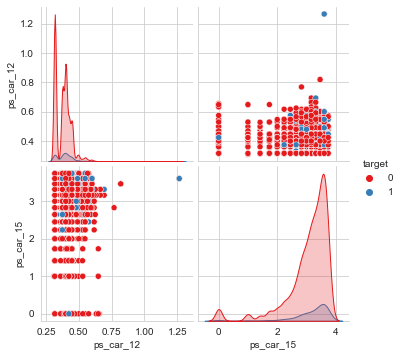

In [75]:
sample = trainset_copy.sample(frac=0.05)
var = ['ps_car_12', 'ps_car_15', 'target']
sample = sample[var]
sns.pairplot(sample,  hue='target', palette = 'Set1', diag_kind='kde')
plt.show()

### Calculated features

기능 ps_calc_01, ps_calc_02 및 ps_calc_03은 분포가 매우 유사하며 최대값이 0.9 모두에 해당하므로 일종의 비율일 수 있습니다. 다른 계산된 값은 최대값인 정수(5,6,7, 10,12)를 갖습니다.


In [76]:
var = metadata[(metadata.type == 'real') & (metadata.preserve)].index
var

Index(['ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_12', 'ps_car_13',
       'ps_car_14', 'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03'],
      dtype='object', name='varname')

<Figure size 432x288 with 0 Axes>

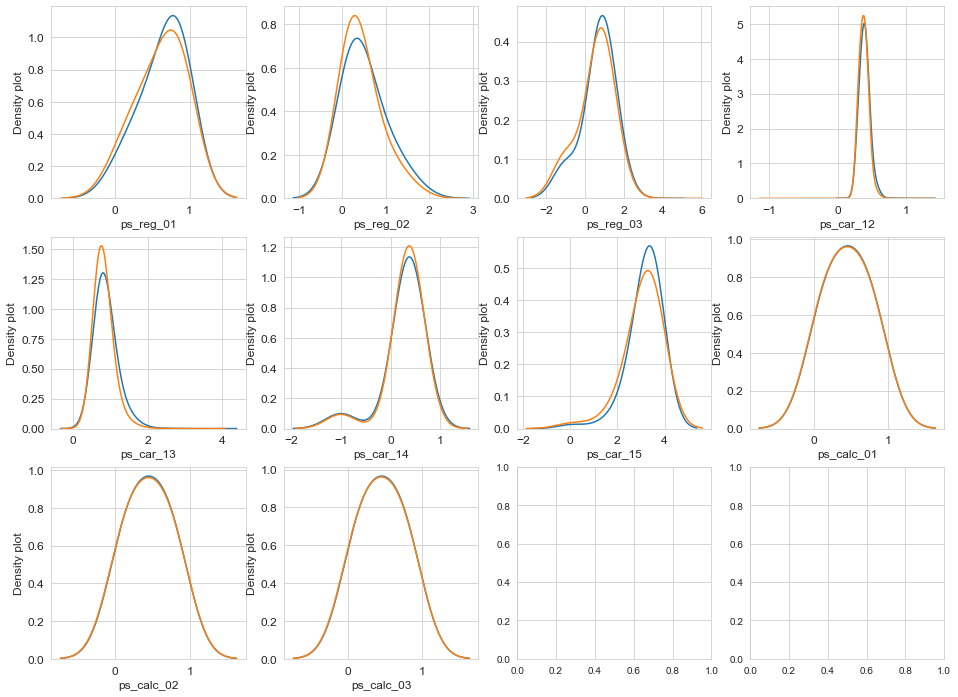

In [77]:
# 인덱스
var = metadata[(metadata.type == 'real') & (metadata.preserve)].index
i = 0
t1 = trainset.loc[trainset['target'] != 0]
t0 = trainset.loc[trainset['target'] == 0]

# 백그라운드
sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(3, 4, figsize=(16,12))

# 그림
for feature in var:
    i += 1
    plt.subplot(3, 4, i) # 가로, 세로, 옆자리
    sns.kdeplot(t1[feature], bw_method=0.85, label="target = 1")
    sns.kdeplot(t0[feature], bw_method=0.85, label="target = 0")
    
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)

plt.show();

ps_reg_02, ps_car_13, ps_car_15는 대상=0 및 대상=1과 관련된 값 집합 간에 가장 다른 분포를 보여줍니다.


real feature 간의 상관 관계를 시각화해 보겠습니다.


            ps_reg_01  ps_reg_02  ps_reg_03  ps_car_12  ps_car_13  ps_car_14  \
ps_reg_01    1.000000   0.471027   0.637035   0.018802   0.027097   0.012704   
ps_reg_02    0.471027   1.000000   0.516457   0.171416   0.194316   0.004147   
ps_reg_03    0.637035   0.516457   1.000000   0.082578   0.099415   0.006271   
ps_car_12    0.018802   0.171416   0.082578   1.000000   0.671720   0.012395   
ps_car_13    0.027097   0.194316   0.099415   0.671720   1.000000  -0.037310   
ps_car_14    0.012704   0.004147   0.006271   0.012395  -0.037310   1.000000   
ps_car_15    0.002765   0.054510   0.022930   0.049882   0.529519  -0.033060   
ps_calc_01  -0.000891   0.001347  -0.001484  -0.000700   0.000157  -0.001191   
ps_calc_02   0.002194  -0.000770   0.002147  -0.000427   0.000040   0.001217   
ps_calc_03  -0.001538   0.000022  -0.000401   0.000172  -0.000200   0.000433   

            ps_car_15  ps_calc_01  ps_calc_02  ps_calc_03  
ps_reg_01    0.002765   -0.000891    0.002194   -0.001538  

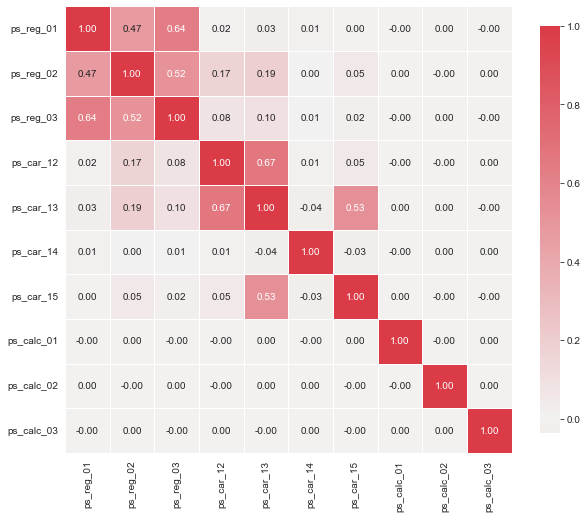

In [78]:
def corr_heatmap(var):
    correlations = trainset[var].corr() # dataframe
    print(correlations)

    # Create color map ranging between two colors
    cmap = sns.diverging_palette(50, 10, as_cmap=True)

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .75})
    plt.show();
    
var = metadata[(metadata.type == 'real') & (metadata.preserve)].index
corr_heatmap(var)


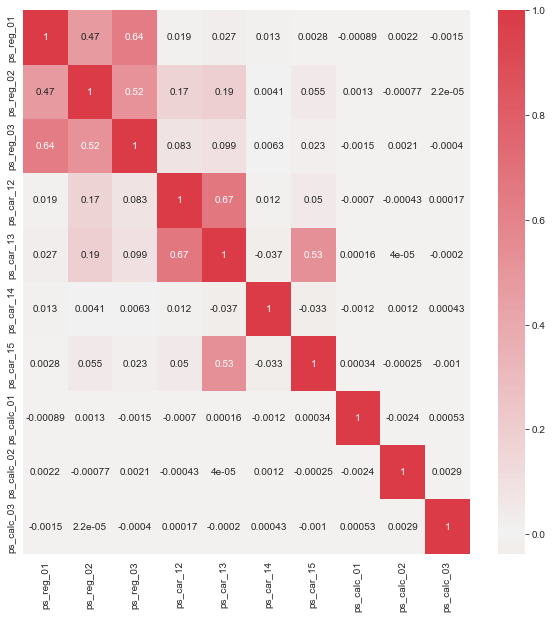

In [79]:
fig, ax = plt.subplots(figsize=(10,10))
var = metadata[(metadata.type == 'real') & (metadata.preserve)].index
sns.heatmap(trainset[var].corr(), cmap = sns.diverging_palette(50,10,as_cmap=True), annot=True,  center=0)
plt.show()

Let's visualize the plots of the variables with strong correlations. These are:

- ps_reg_01 with ps_reg_02 (0.47);
- ps_reg_01 with ps_reg_03 (0.64);
- ps_reg_02 with ps_reg_03 (0.52);
- ps_car_12 with ps_car_13 (0.67);
- ps_car_13 with ps_car_15 (0.53);

To show the pairs of values that are correlated we use pairplot. Before representing the pairs, we subsample the data, using only 2% in the sample.



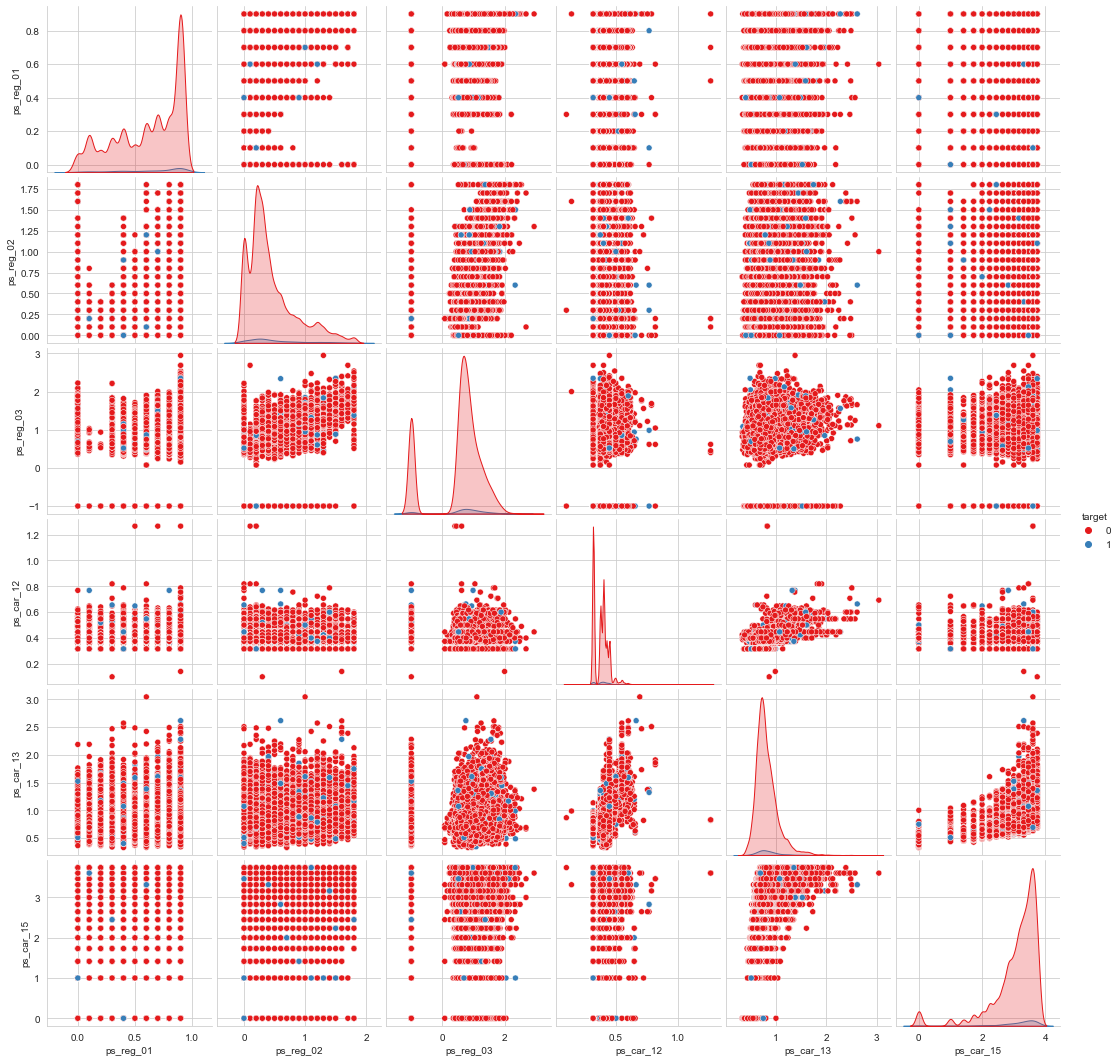

In [80]:
sample = trainset.sample(frac=0.05)
var = ['ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_12', 'ps_car_13', 'ps_car_15', 'target']
sample = sample[var]
sns.pairplot(sample,  hue='target', palette = 'Set1', diag_kind='kde')
plt.show()

## Binary features


In [81]:
v = metadata[(metadata.type == 'binary') & (metadata.preserve)].index
trainset[v].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


train 데이터 세트에 이진 데이터의 분포를 표시해 보겠습니다. 파란색은 0의 백분율을 나타내고 빨간색은 1의 백분율을 나타냅니다.


C:\Users\HOME\AppData\Local\Temp/ipykernel_13436/3610471628.py:18: UserWarning: Legend does not support <AxesSubplot:xlabel='Binary features', ylabel='Percent of zero/one [%]'> instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend((p1, p2), ('Zero', 'One'))


<Figure size 432x288 with 0 Axes>

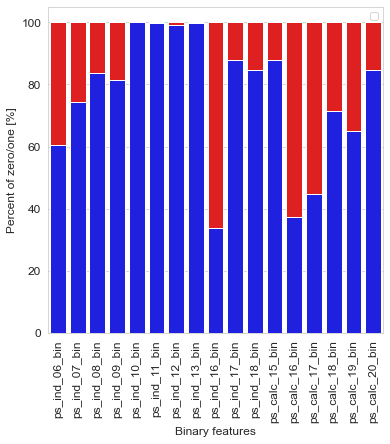

In [82]:
bin_col = [col for col in trainset.columns if '_bin' in col]
zero_list = []
one_list = []
for col in bin_col:
    zero_list.append((trainset[col]==0).sum()/trainset.shape[0]*100) # trainset.shape[0]=열개수
    one_list.append((trainset[col]==1).sum()/trainset.shape[0]*100)
plt.figure()
fig, ax = plt.subplots(figsize=(6,6))

# Bar plot
p1 = sns.barplot(ax=ax, x=bin_col, y=zero_list, color="blue")
p2 = sns.barplot(ax=ax, x=bin_col, y=one_list, bottom= zero_list, color="red")
plt.ylabel('Percent of zero/one [%]', fontsize=12)
plt.xlabel('Binary features', fontsize=12)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend((p1, p2), ('Zero', 'One'))
plt.show();

In [83]:
trainset.shape

(595212, 59)

<Figure size 432x288 with 0 Axes>

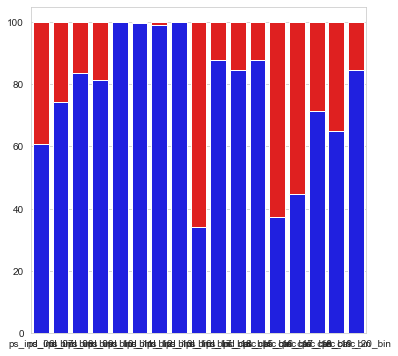

In [84]:
bin_col = [f for f in trainset.columns if '_bin' in f]
zero_list = [] # [60.62579383480172, 74.29672116825601, ..., 81.469627628]
one_list = [] # [39.37420616519828, 25.703278831743987, ..., 15.331848148222818]
for col in bin_col:
    zero_list.append((trainset[col]==0).sum()/trainset.shape[0]*100)
    one_list.append((trainset[col]==1).sum()/trainset.shape[0]*100)

plt.figure()
fig, ax = plt.subplots(figsize =(6,6))

p1 = sns.barplot(ax=ax, x=bin_col, y=zero_list, color='blue')
p2 = sns.barplot(ax=ax, x=bin_col, y=one_list, bottom=zero_list, color='red')


ps_ind_10_bin, ps_ind_11_bin, ps_ind_12_bin 및 ps_ind_13_bin은 매우 작은 수의 값 1(0.5% 미만)을 갖는 반면 ps_ind_16_bin 및 ps_cals_16_bin(60% 이상)의 경우 값 1이 매우 큽니다.

이제 이항 데이터의 분포와 대상 변수의 해당 값을 살펴보겠습니다.

<Figure size 432x288 with 0 Axes>

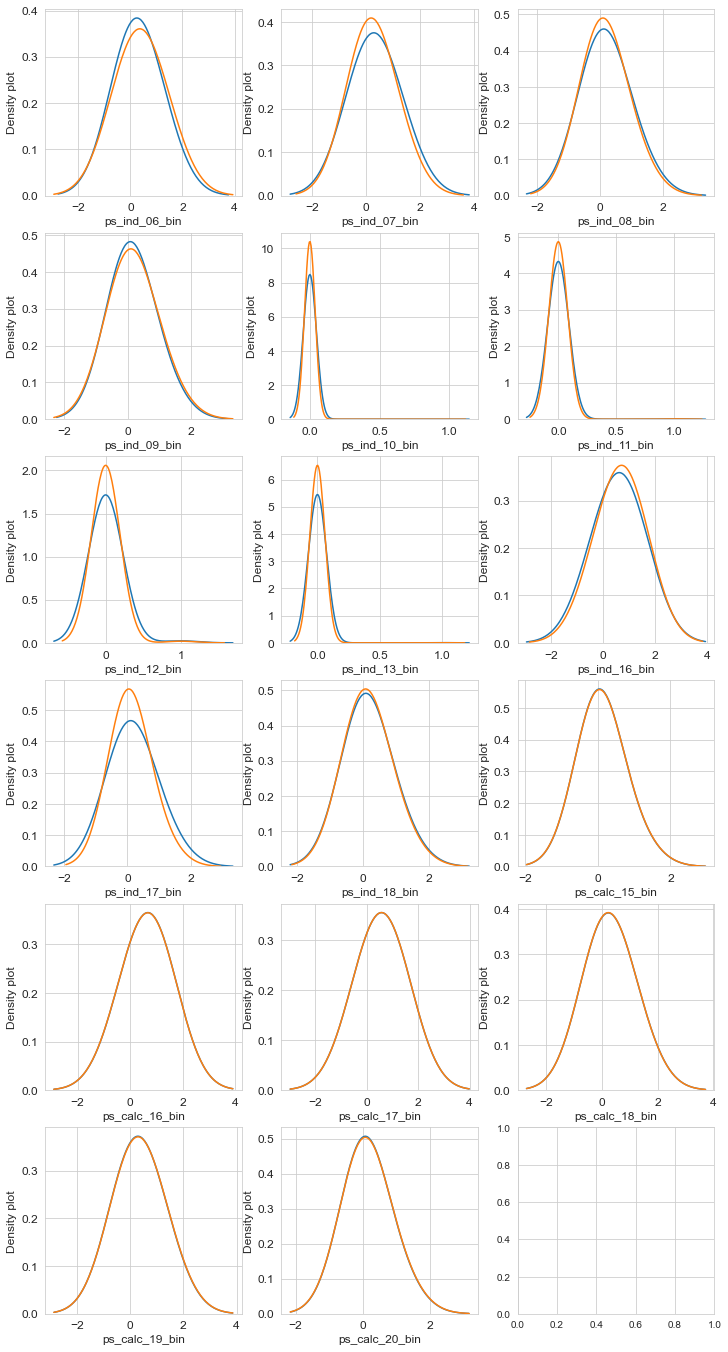

In [85]:
var = metadata[(metadata.type == 'binary') & (metadata.preserve)].index
var = [col for col in trainset.columns if '_bin' in col]
i = 0
t1 = trainset.loc[trainset['target'] != 0]
t0 = trainset.loc[trainset['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(6,3,figsize=(12,24))

for feature in var:
    i += 1
    plt.subplot(6,3,i)
    sns.kdeplot(t1[feature], bw_method=2,label="target = 1")
    sns.kdeplot(t0[feature], bw_method=2,label="target = 0")
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

ps_ind_06_bin, ps_ind_07_bin, ps_ind_16_bin, ps_ind_17_bin은 대상 값이 1과 0인 경우 값 1과 0의 분포 간에 높은 불균형을 보이고, ps_ind_08_bin은 잘 균형화되어 밀도도가 유사합니다.


## Categorical features


범주형 데이터에 대한 분포를 두 가지 방법으로 나타낼 것입니다. 
먼저 범주 값당 목표값의 백분율=1을 계산하고 막대 그림을 사용하여 이러한 백분율을 나타냅니다.


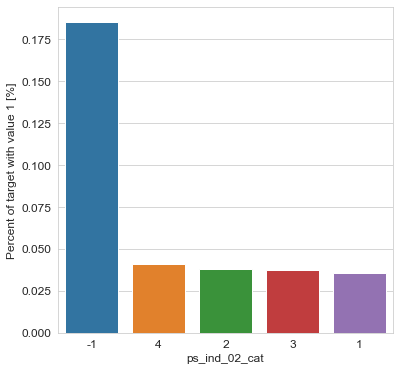

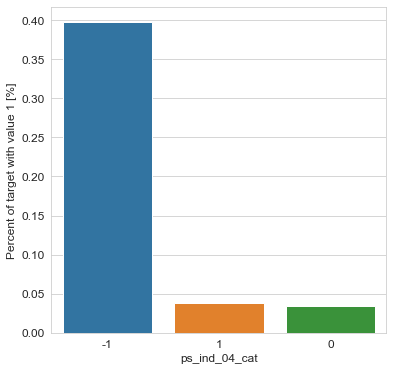

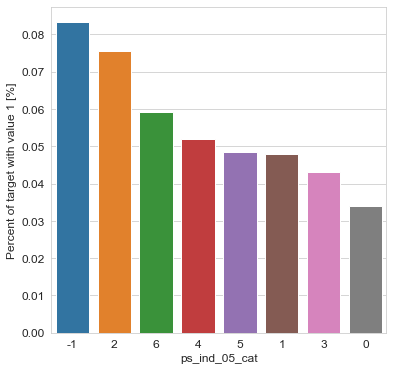

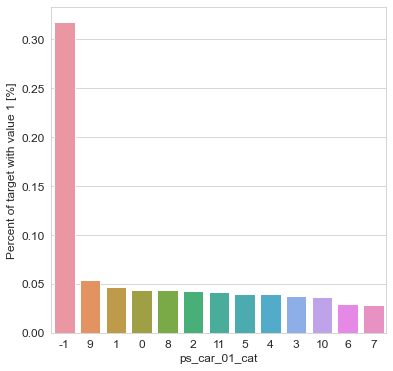

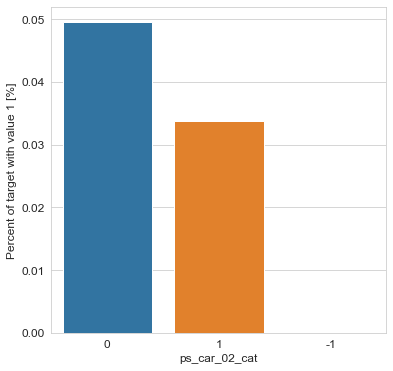

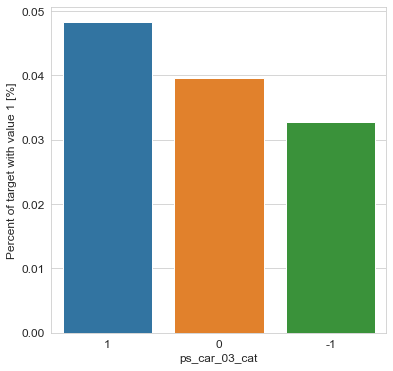

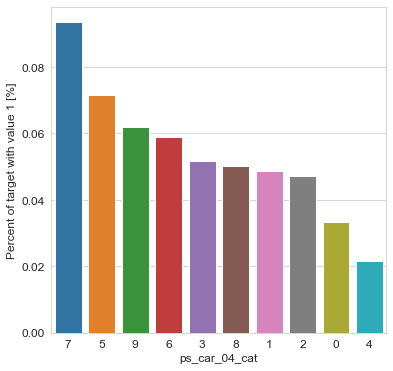

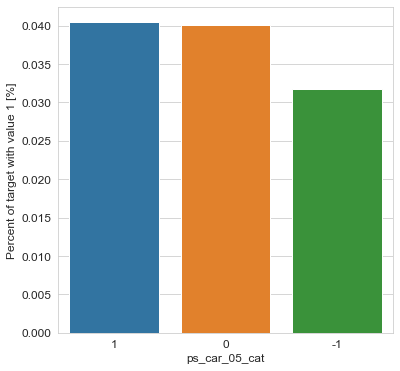

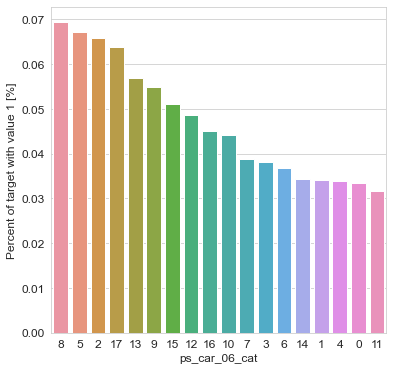

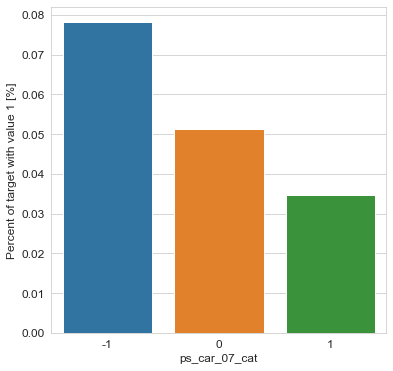

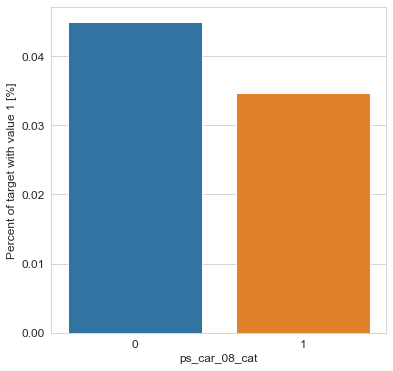

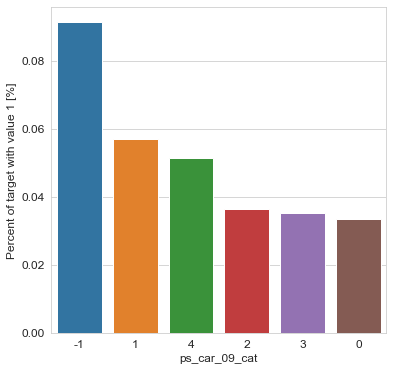

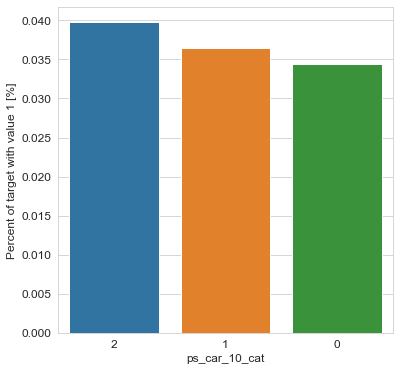

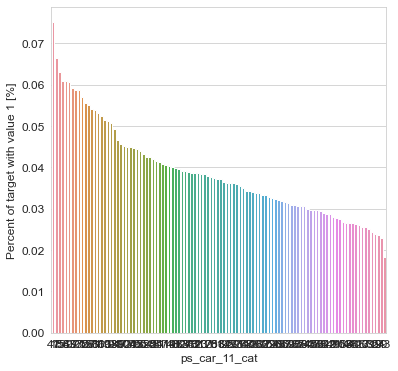

In [86]:
var = metadata[(metadata.type == 'categorical') & (metadata.preserve)].index

for feature in var:
    fig, ax = plt.subplots(figsize=(6,6))
    # Calculate the percentage of target=1 per category value
    cat_perc = trainset[[feature, 'target']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='target', ascending=False, inplace=True)
    # Bar plot
    # Order the bars descending on target mean
    sns.barplot(ax=ax,x=feature, y='target', data=cat_perc, order=cat_perc[feature])
    plt.ylabel('Percent of target with value 1 [%]', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();

또는 밀도도를 사용하여 범주형 특징을 나타냅니다. 목표값=0 및 목표값=1인 값을 선택하고 두 밀도도를 동일한 그래픽에 나타냅니다.


<Figure size 432x288 with 0 Axes>

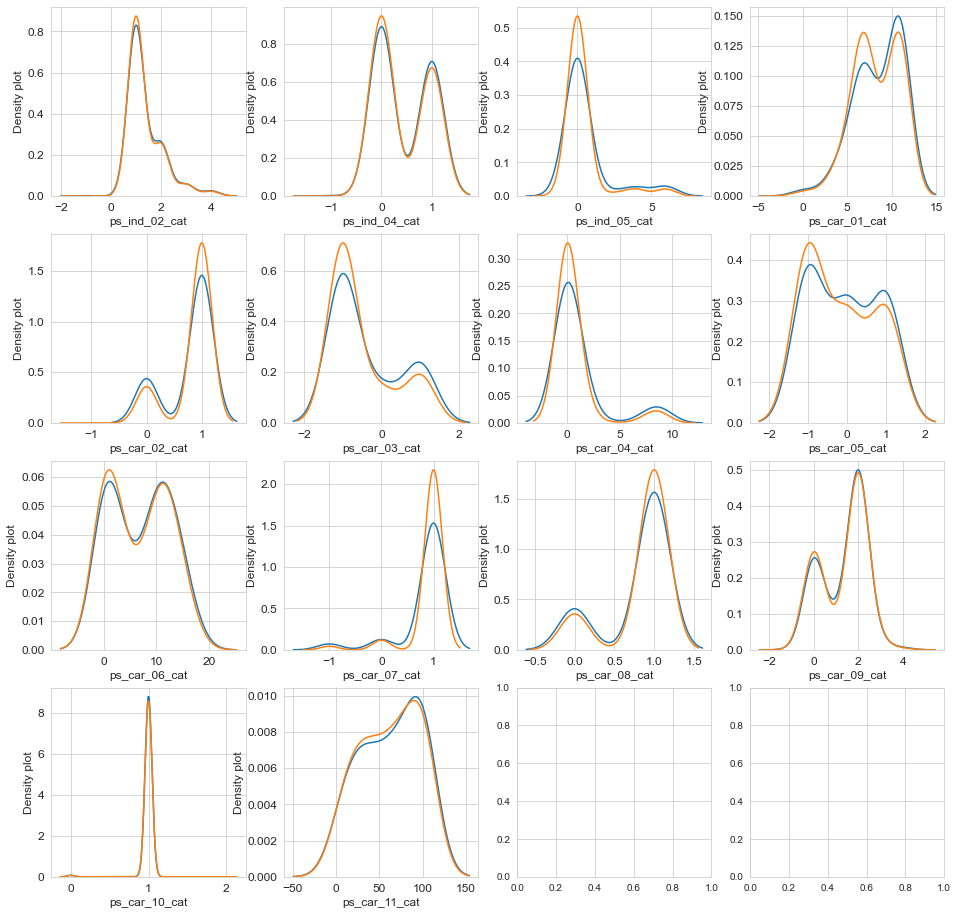

In [87]:
var = metadata[(metadata.type == 'categorical') & (metadata.preserve)].index
i = 0
t1 = trainset.loc[trainset['target'] != 0]
t0 = trainset.loc[trainset['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(4,4,figsize=(16,16))

for feature in var:
    i += 1
    plt.subplot(4,4,i)
    sns.kdeplot(t1[feature], bw_method=0.5,label="target = 1")
    sns.kdeplot(t0[feature], bw_method=0.5,label="target = 0")
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

ps_car_03_cat, ps_car_05_cat는 목표값=0 및 목표값=1과 관련된 값 간에 가장 다른 밀도 그림을 보여줍니다.


### Data unbalance between train and test data

Let's compare the distribution of the features in the train and test datasets.

We start with the reg or registration features.



<Figure size 432x288 with 0 Axes>

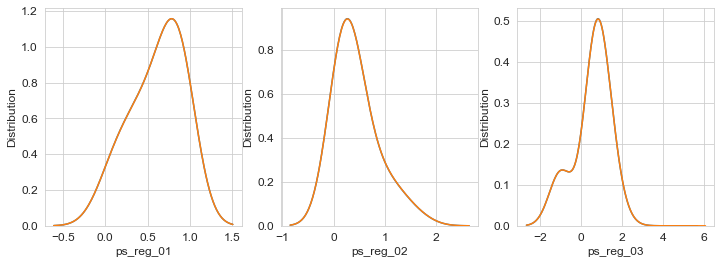

In [88]:
var = metadata[(metadata.category == 'registration') & (metadata.preserve)].index

# Bar plot
sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(1,3,figsize=(12,4))
i = 0

for feature in var:
    i = i + 1
    plt.subplot(1,3,i)
    sns.kdeplot(trainset[feature], bw_method=0.7, label="train")
    sns.kdeplot(testset[feature], bw_method=0.7, label="test")
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    #plt.setp(labels, rotation=90)
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

All reg features shows well balanced train and test sets.





Let's continue with car features.

<Figure size 432x288 with 0 Axes>

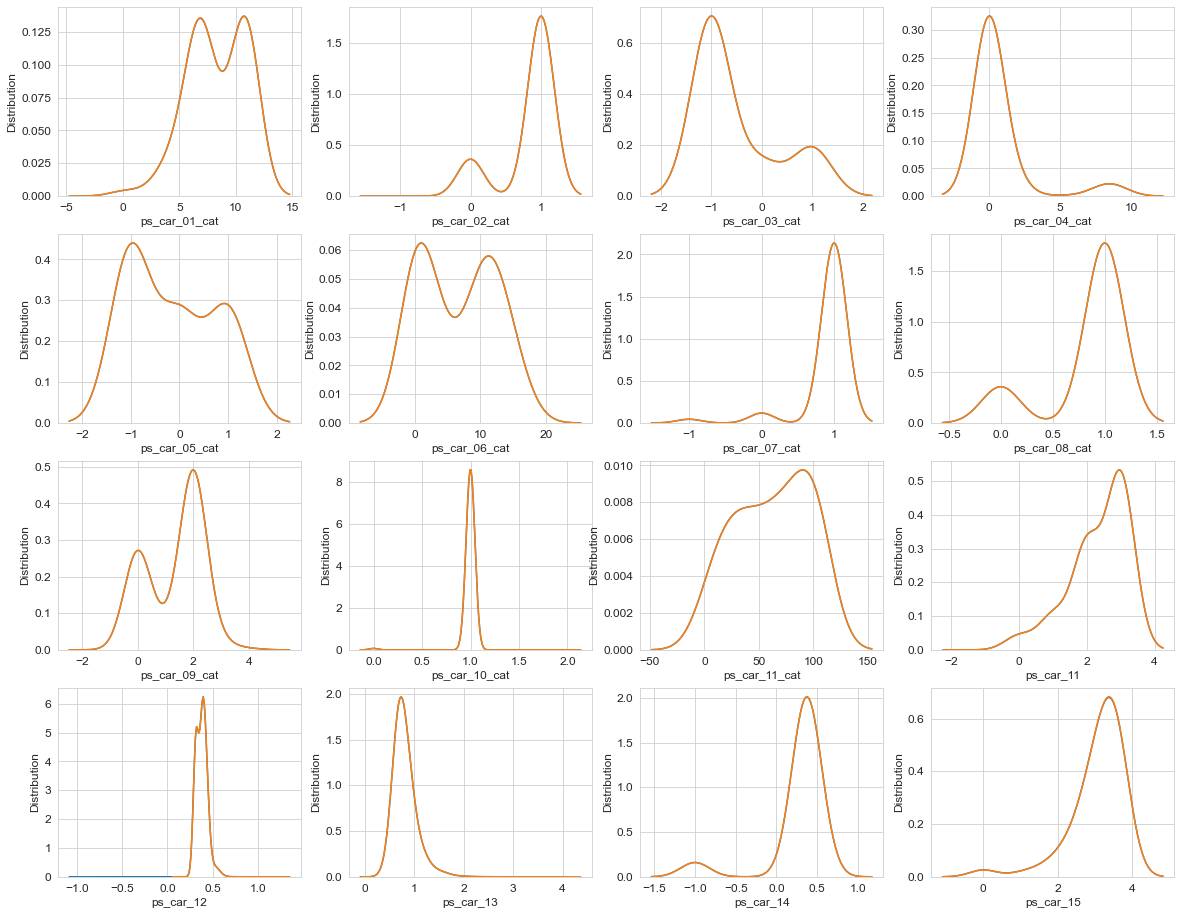

In [89]:
var = metadata[(metadata.category == 'car') & (metadata.preserve)].index

# Bar plot
sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(4,4,figsize=(20,16))
i = 0
for feature in var:
    i = i + 1
    plt.subplot(4,4,i)
    sns.kdeplot(trainset[feature], bw_method=0.5, label="train")
    sns.kdeplot(testset[feature], bw_method=0.5, label="test")
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    #plt.setp(labels, rotation=90)
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();


From the car features, all variables looks well balanced between train and test set.

Let's look now to the ind (individual) values.



<Figure size 432x288 with 0 Axes>

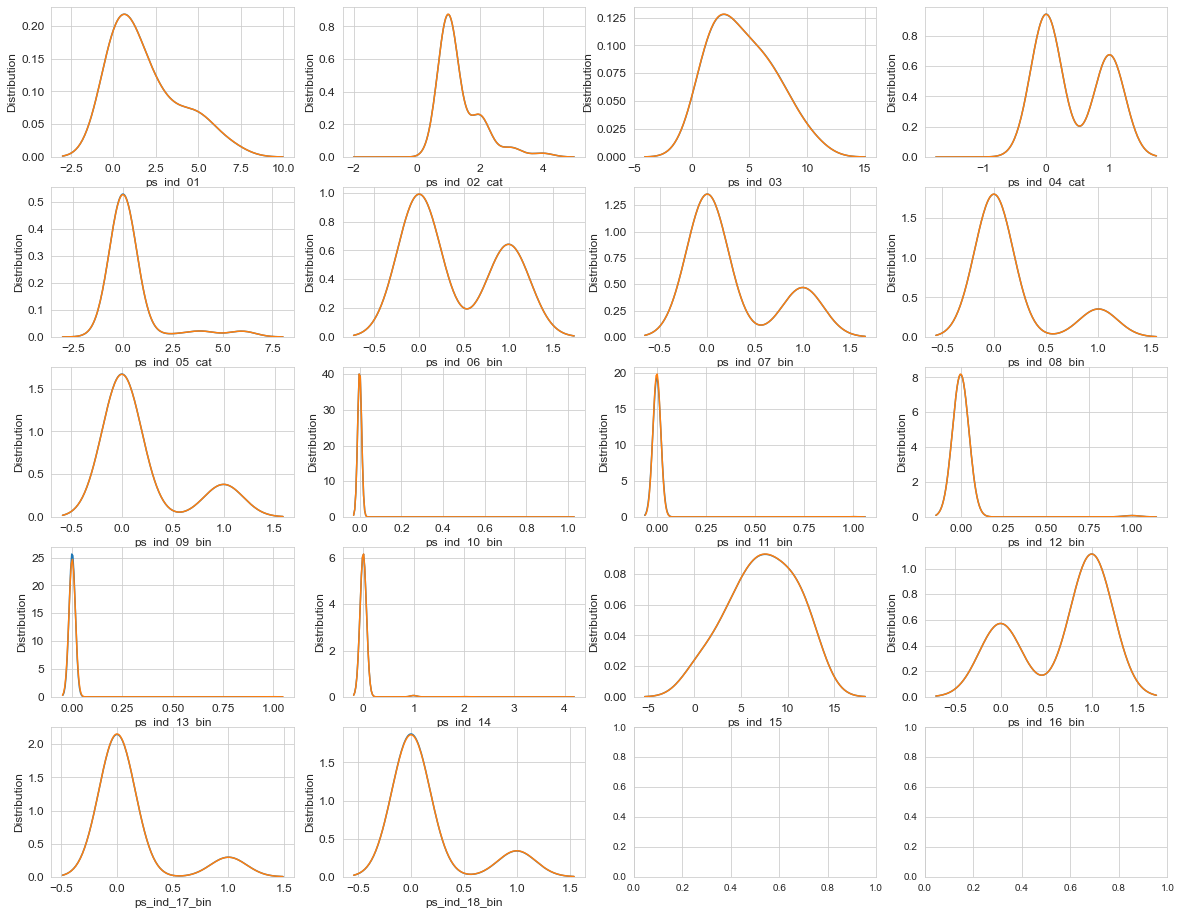

In [90]:
var = metadata[(metadata.category == 'individual') & (metadata.preserve)].index

# Bar plot
sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(5,4,figsize=(20,16))
i = 0
for feature in var:
    i = i + 1
    plt.subplot(5,4,i)
    sns.kdeplot(trainset[feature], bw_method=0.5, label="train")
    sns.kdeplot(testset[feature], bw_method=0.5, label="test")
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    #plt.setp(labels, rotation=90)
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

All ind features are well balanced between train and test sets.

Let's check now calc features.



<Figure size 432x288 with 0 Axes>

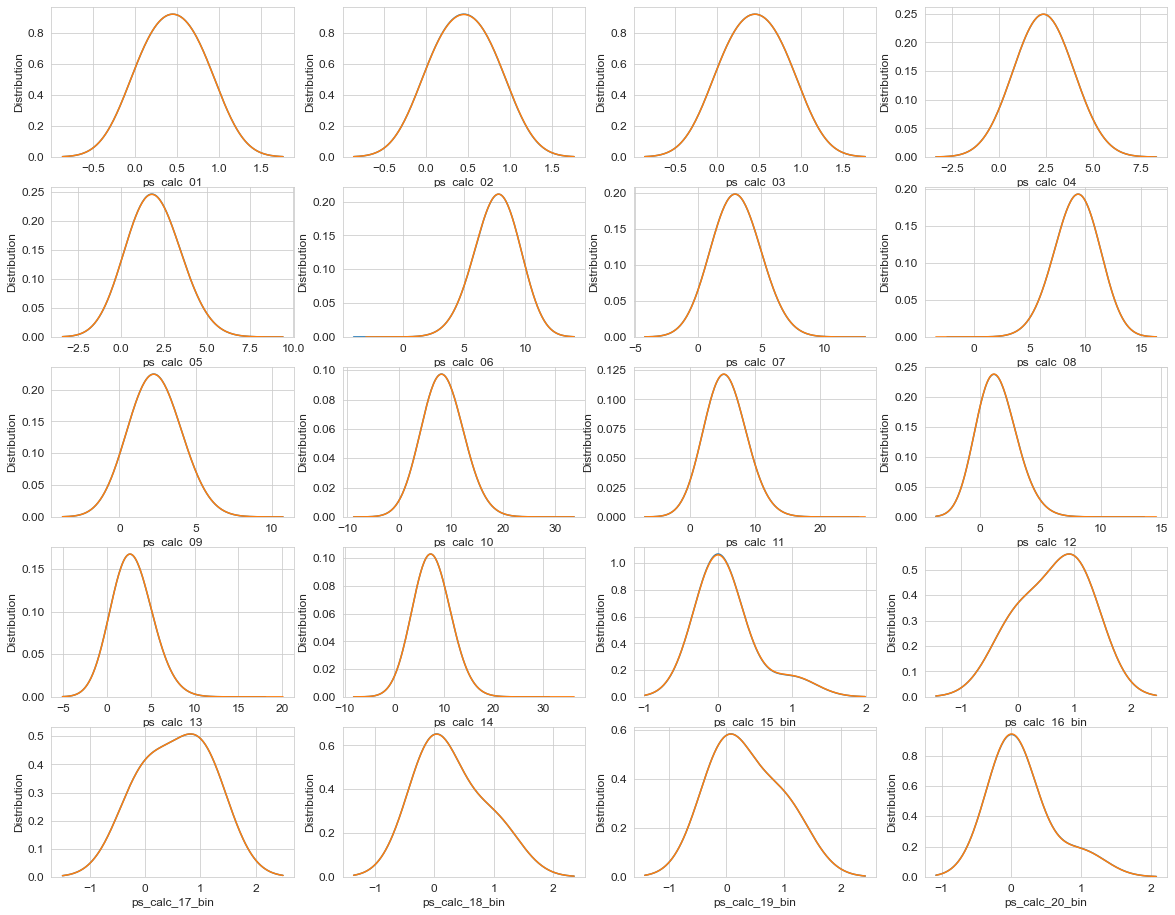

In [91]:
var = metadata[(metadata.category == 'calculated') & (metadata.preserve)].index

# Bar plot
sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(5,4,figsize=(20,16))
i = 0
for feature in var:
    i = i + 1
    plt.subplot(5,4,i)
    sns.kdeplot(trainset[feature], bw_method=1, label="train")
    sns.kdeplot(testset[feature], bw_method=1, label="test")
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    #plt.setp(labels, rotation=90)
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

All calc features are well balanced between train and test sets.

참고문헌 [5]에서도 열차와 테스트 세트 사이의 균형이 잘 잡혀 있는 것이 눈에 띕니다. 또한 계산 기능은 모두 엔지니어링되어 있지만 실제로는 관련이 없을 수 있습니다. 이는 하나 이상의 예측 모델을 사용한 CV 점수를 사용하여 신중하게 성공적으로 제거해야만 평가할 수 있습니다.


# Check data quality

Let's inspect the features with missing values:



In [92]:
vars_with_missing = []

for feature in trainset.columns:
    missings = trainset[trainset[feature] == -1][feature].count()
    if missings > 0:
        vars_with_missing.append(feature)
        missings_perc = missings/trainset.shape[0]
        
        print('Variable {} has {} records ({:.2%}) with missing values'.format(feature, missings, missings_perc))
        
print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))

Variable ps_ind_02_cat has 216 records (0.04%) with missing values
Variable ps_ind_04_cat has 83 records (0.01%) with missing values
Variable ps_ind_05_cat has 5809 records (0.98%) with missing values
Variable ps_reg_03 has 107772 records (18.11%) with missing values
Variable ps_car_01_cat has 107 records (0.02%) with missing values
Variable ps_car_02_cat has 5 records (0.00%) with missing values
Variable ps_car_03_cat has 411231 records (69.09%) with missing values
Variable ps_car_05_cat has 266551 records (44.78%) with missing values
Variable ps_car_07_cat has 11489 records (1.93%) with missing values
Variable ps_car_09_cat has 569 records (0.10%) with missing values
Variable ps_car_11 has 5 records (0.00%) with missing values
Variable ps_car_12 has 1 records (0.00%) with missing values
Variable ps_car_14 has 42620 records (7.16%) with missing values
In total, there are 13 variables with missing values


# Prepare the data for model

### Drop calc columns

[5]에서 권장하는 대로 calc 열도 삭제합니다. 이것은 모두 조작된 것으로 보이며, 드미트리 알투호프에 따르면, 그는 모든 것을 성공적으로 제거하면서 CV 점수를 향상시킬 수 있었습니다.



In [93]:
col_to_drop = trainset.columns[trainset.columns.str.startswith('ps_calc_')]
trainset = trainset.drop(col_to_drop, axis=1)  
testset = testset.drop(col_to_drop, axis=1)  

#### Drop variables with too many missing values

We select from the variables with missing values two, ps_car_03_cat and ps_car_05_cat to drop.

In [94]:
# Dropping the variables with too many missing values
vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
trainset.drop(vars_to_drop, inplace=True, axis=1)
testset.drop(vars_to_drop, inplace=True, axis=1)
metadata.loc[(vars_to_drop),'keep'] = False  # Updating the meta

카테고리 범주(1,2,3,4,.. 100)가 많은 카테고리를 숫자형태로 변환

In [95]:
# Script by https://www.kaggle.com/ogrellier
# Code: https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # assert는 이 조건이 참일때 코드는 내가 보장한다. 이 조건은 올바르다!
    # 하지만 이 조건이 거짓이라는 것은 내가 보증하지 않은 동작이다. 그러니 AssertionError를 발생해라.

    
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    print(trn_series.name)
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing)) # 1/1+exp(개수-100)
    
    # Apply average function to all target data
    prior = target.mean()
    
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

ps_car_11_cat을 인코딩된 값으로 바꿉니다.
target_encode 함수를 사용하여 ps_car_11_cat을 열차 및 테스트 데이터 세트 모두에서 인코딩된 값으로 대체합니다.


In [96]:
train_encoded, test_encoded = target_encode(trainset["ps_car_11_cat"], 
                             testset["ps_car_11_cat"], 
                             target=trainset.target, 
                             min_samples_leaf=100,
                             smoothing=10,
                             noise_level=0.01)
    
trainset['ps_car_11_cat_te'] = train_encoded
trainset.drop('ps_car_11_cat', axis=1, inplace=True)
metadata.loc['ps_car_11_cat','keep'] = False  # Updating the metadata
testset['ps_car_11_cat_te'] = test_encoded
testset.drop('ps_car_11_cat', axis=1, inplace=True)

ps_car_11_cat


### Balance target variable

The target variable is highly unbalanced. This can be improved by either undersampling values with target = 0 or oversampling values with target = 1. Because there is a rather large training set, we opt for the undersampling.



In [97]:
desired_apriori=0.10

# Get the indices per target value
idx_0 = trainset[trainset.target == 0].index
idx_1 = trainset[trainset.target == 1].index

# Get original number of records per target value
nb_0 = len(trainset.loc[idx_0])
nb_1 = len(trainset.loc[idx_1])

# Calculate the undersampling rate and resulting number of records with target=0
undersampling_rate = ((1-desired_apriori)*nb_1)/(nb_0*desired_apriori)
undersampled_nb_0 = int(undersampling_rate*nb_0)
print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_0))

# Randomly select records with target=0 to get at the desired a priori
undersampled_idx = shuffle(idx_0, random_state=314, n_samples=undersampled_nb_0)

# Construct list with remaining indices
idx_list = list(undersampled_idx) + list(idx_1)

# Return undersample data frame
trainset = trainset.loc[idx_list].reset_index(drop=True)

Rate to undersample records with target=0: 0.34043569687437886
Number of records with target=0 after undersampling: 195246


##### Replace -1 values with NaN

Most of the classifiers we would use have preety good strategies to manage missing (or NaN) values.


In [98]:
trainset = trainset.replace(-1, np.nan)
testset = testset.replace(-1, np.nan)

#### Dummify cat values

We will create dummy variables for the categorical (cat) features



In [99]:
cat_features = [a for a in trainset.columns if a.endswith('cat')]

for column in cat_features:
    temp = pd.get_dummies(pd.Series(trainset[column]))
    trainset = pd.concat([trainset,temp],axis=1)
    trainset = trainset.drop([column],axis=1)
    
for column in cat_features:
    temp = pd.get_dummies(pd.Series(testset[column]))
    testset = pd.concat([testset,temp],axis=1)
    testset = testset.drop([column],axis=1)

#### Drop unused and target columns

We separate the id and target (drop these columns)



In [100]:
id_test = testset['id'].values
target_train = trainset['target'].values

trainset = trainset.drop(['target','id'], axis = 1)
testset = testset.drop(['id'], axis = 1)

Let's inspect the training and test sets:



In [101]:
print("Train dataset (rows, cols):",trainset.values.shape, "\nTest dataset (rows, cols):",testset.values.shape)

Train dataset (rows, cols): (216940, 91) 
Test dataset (rows, cols): (892816, 91)


# Prepare the model

### Ensamble class for cross validation and ensamble
KFolds에서 데이터를 분할하고 모델을 교육한 후 결과를 Ensamble 클래스를 준비합니다.

클래스에는 4개의 매개 변수를 허용하는 init 메서드(Ensamble 객체가 생성될 때 호출)가 있습니다.

- self - 초기화할 개체입니다.
- n_splits - 사용될 교차 검증 분할 수입니다.
- stacker - 훈련된 기준 모형의 예측 결과를 쌓는 데 사용되는 모형입니다.
- base_models - 교육에 사용되는 기본 모델의 목록입니다.

두 번째 방법인 fit_pedict에는 네 가지 함수가 있습니다.

- 훈련 데이터를 n_split 접힘으로 분할합니다;

- 각 폴드에 대해 기본 모델을 실행합니다;

- 각 모형을 사용하여 예측을 수행합니다.

- Stacker를 사용하여 결과를 앙상블합니다;

In [102]:
class Ensemble(object):
    def __init__(self, n_splits, stacker, base_models):
        self.n_splits = n_splits
        self.stacker = stacker
        self.base_models = base_models

    def fit_predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)

        folds = list(StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=314).split(X, y))

        S_train = np.zeros((X.shape[0], len(self.base_models)))
        S_test = np.zeros((T.shape[0], len(self.base_models)))
        for i, clf in enumerate(self.base_models):

            S_test_i = np.zeros((T.shape[0], self.n_splits))

            for j, (train_idx, test_idx) in enumerate(folds):
                X_train = X[train_idx]
                y_train = y[train_idx]
                X_holdout = X[test_idx]


                print ("Base model %d: fit %s model | fold %d" % (i+1, str(clf).split('(')[0], j+1))
                clf.fit(X_train, y_train)
                cross_score = cross_val_score(clf, X_train, y_train, cv=3, scoring='roc_auc')
                print("cross_score [roc-auc]: %.5f [gini]: %.5f" % (cross_score.mean(), 2*cross_score.mean()-1))
                y_pred = clf.predict_proba(X_holdout)[:,1]                

                S_train[test_idx, i] = y_pred
                S_test_i[:, j] = clf.predict_proba(T)[:,1]
            S_test[:, i] = S_test_i.mean(axis=1)

        results = cross_val_score(self.stacker, S_train, y, cv=3, scoring='roc_auc')
        # Calculate gini factor as 2 * AUC - 1
        print("Stacker score [gini]: %.5f" % (2 * results.mean() - 1))

        self.stacker.fit(S_train, y)
        res = self.stacker.predict_proba(S_test)[:,1]
        return res

#### Parameters for the base models

기본 모델은 LightGBM 모델 3개와 XGB 모델 1개를 준비합니다.

각 모형은 데이터를 교육하는 데 사용됩니다(세 번 접기 및 교차 검증 사용).



In [103]:
# LightGBM params
# lgb_1
lgb_params1 = {}
lgb_params1['learning_rate'] = 0.02
lgb_params1['n_estimators'] = 650
lgb_params1['max_bin'] = 10
lgb_params1['subsample'] = 0.8
lgb_params1['subsample_freq'] = 10
lgb_params1['colsample_bytree'] = 0.8   
lgb_params1['min_child_samples'] = 500
lgb_params1['seed'] = 314
lgb_params1['num_threads'] = 4

# lgb2
lgb_params2 = {}
lgb_params2['n_estimators'] = 1090
lgb_params2['learning_rate'] = 0.02
lgb_params2['colsample_bytree'] = 0.3   
lgb_params2['subsample'] = 0.7
lgb_params2['subsample_freq'] = 2
lgb_params2['num_leaves'] = 16
lgb_params2['seed'] = 314
lgb_params2['num_threads'] = 4

# lgb3
lgb_params3 = {}
lgb_params3['n_estimators'] = 1100
lgb_params3['max_depth'] = 4
lgb_params3['learning_rate'] = 0.02
lgb_params3['seed'] = 314
lgb_params3['num_threads'] = 4

# XGBoost params
xgb_params = {}
xgb_params['objective'] = 'binary:logistic'
xgb_params['learning_rate'] = 0.04
xgb_params['n_estimators'] = 490
xgb_params['max_depth'] = 4
xgb_params['subsample'] = 0.9
xgb_params['colsample_bytree'] = 0.9  
xgb_params['min_child_weight'] = 10
xgb_params['num_threads'] = 4